Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:08<00:00, 1.19MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 6.77MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.01MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



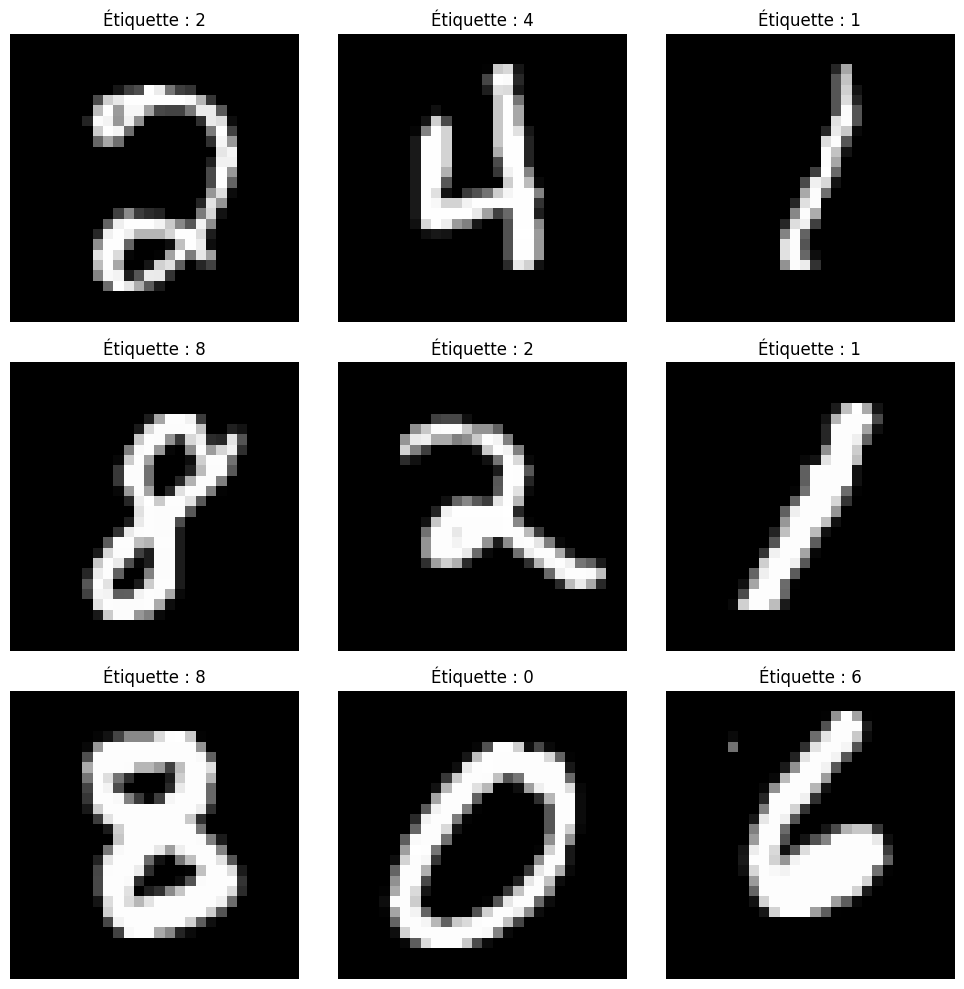

In [6]:
#Partie 1. 1

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformer les données pour les normaliser entre 0 et 1
transform = transforms.Compose([transforms.ToTensor()])

# Télécharger et charger le jeu de données MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True)

# Obtenir un lot d'exemples d'images et d'étiquettes
images, labels = next(iter(train_loader))

# Afficher les images avec leurs étiquettes
plt.figure(figsize=(10, 10))

for i in range(len(images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')  # Afficher en niveaux de gris
    plt.title(f"Étiquette : {labels[i].item()}")  # Afficher l'étiquette
    plt.axis('off')  # Masquer les axes

plt.tight_layout()
plt.show()



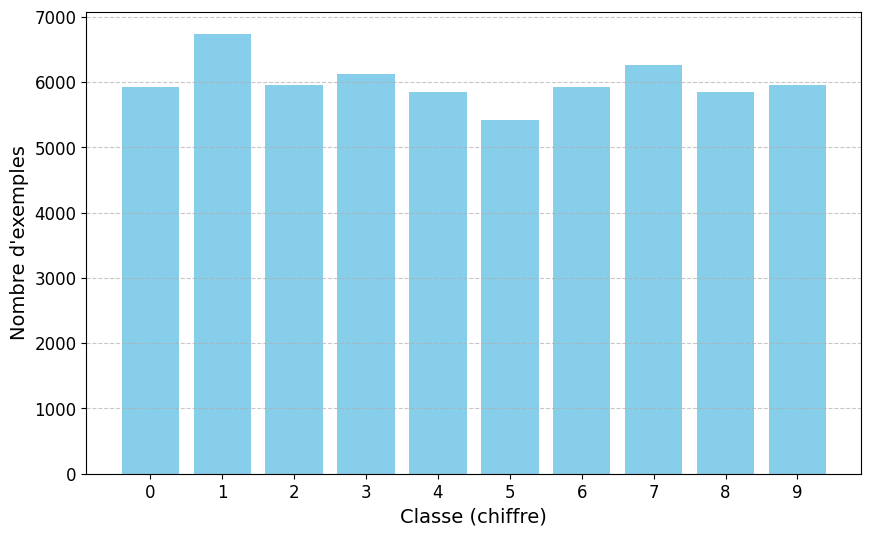

In [9]:
#Partie 1.2

import numpy as np

# Transformer les données pour les normaliser entre 0 et 1
transform = transforms.Compose([transforms.ToTensor()])

# Télécharger et charger le jeu de données MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Extraire les étiquettes de toutes les données d'entraînement
labels = np.array(train_dataset.targets)

# Compter le nombre d'exemples pour chaque classe (de 0 à 9)
unique_labels, counts = np.unique(labels, return_counts=True)

# Afficher les résultats sous forme de barres
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Classe (chiffre)", fontsize=14)
plt.ylabel("Nombre d'exemples", fontsize=14)
# plt.title("Distribution des étiquettes dans le jeu de données MNIST", fontsize=16)
plt.xticks(unique_labels, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Pourcentage des données : 0.1% - Précision sur l'ensemble de test : 0.4682
Pourcentage des données : 1% - Précision sur l'ensemble de test : 0.8426
Pourcentage des données : 10% - Précision sur l'ensemble de test : 0.9676
Pourcentage des données : 20% - Précision sur l'ensemble de test : 0.9793
Pourcentage des données : 50% - Précision sur l'ensemble de test : 0.9874
Pourcentage des données : 80% - Précision sur l'ensemble de test : 0.9841


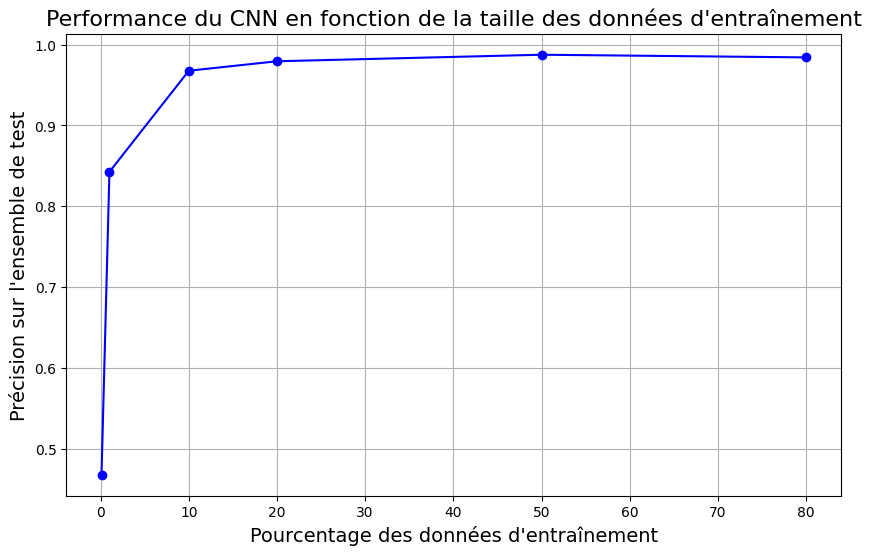

In [10]:
#Partie 1.3

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Définir le CNN (structure de la Table 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Conv2
        self.pool = nn.MaxPool2d(2)  # Pooling
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Fully connected 1
        self.fc2 = nn.Linear(128, 10)  # Fully connected 2 (Output layer)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Définir les transformations
transform = transforms.Compose([transforms.ToTensor()])

# Charger les données MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Hyperparamètres
batch_size = 64
learning_rate = 0.001
num_epochs = 5
percentages = [0.1, 1, 10, 20, 50, 80]  # Pourcentages des données d'entraînement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Préparer l'ensemble de test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fonction pour entraîner et évaluer le modèle
def train_and_evaluate(train_loader, test_loader, model, criterion, optimizer):
    # Entraînement
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Évaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Boucle sur les pourcentages
results = []
for percentage in percentages:
    subset_size = int(len(train_dataset) * (percentage / 100))
    subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    subset = Subset(train_dataset, subset_indices)
    train_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    
    # Initialiser le modèle, la fonction de perte et l'optimiseur
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Entraîner et évaluer
    accuracy = train_and_evaluate(train_loader, test_loader, model, criterion, optimizer)
    results.append(accuracy)
    print(f"Pourcentage des données : {percentage}% - Précision sur l'ensemble de test : {accuracy:.4f}")

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(percentages, results, marker='o', color='b')
plt.xlabel("Pourcentage des données d'entraînement", fontsize=14)
plt.ylabel("Précision sur l'ensemble de test", fontsize=14)
plt.title("Performance du CNN en fonction de la taille des données d'entraînement", fontsize=16)
plt.grid()
plt.show()


In [11]:
#Partie 1.4 


# Définir le modèle linéaire (structure de la Table 2)
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)  # Fully connected 1
        self.fc2 = nn.Linear(512, 256)  # Fully connected 2
        self.fc3 = nn.Linear(256, 128)  # Fully connected 3
        self.fc4 = nn.Linear(128, 10)  # Fully connected 4 (Output layer)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir l'entrée (28x28 → 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Définir les transformations
transform = transforms.Compose([transforms.ToTensor()])

# Charger les données MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Préparer les sous-ensembles et le DataLoader
subset_size = int(len(train_dataset) * 0.001)  # 0.1% des données
subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
subset = Subset(train_dataset, subset_indices)
train_loader = DataLoader(subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialiser le modèle, la fonction de perte et l'optimiseur
model_linear = LinearModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_linear.parameters(), lr=0.001)

# Fonction d'entraînement et d'évaluation
def train_and_evaluate(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    # Entraînement
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Évaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Entraîner et évaluer le modèle linéaire
accuracy_linear = train_and_evaluate(train_loader, test_loader, model_linear, criterion, optimizer)
print(f"Précision du modèle linéaire sur l'ensemble de test (0,1% des données) : {accuracy_linear:.4f}")

# Pour comparer avec le CNN, réutiliser le modèle CNN défini précédemment et entraîner sur le même ensemble
model_cnn = CNN().to(device)
accuracy_cnn = train_and_evaluate(train_loader, test_loader, model_cnn, criterion, optimizer)
print(f"Précision du modèle CNN sur l'ensemble de test (0,1% des données) : {accuracy_cnn:.4f}")


Précision du modèle linéaire sur l'ensemble de test (0,1% des données) : 0.2637
Précision du modèle CNN sur l'ensemble de test (0,1% des données) : 0.1125


Modèle linéaire (précision : 26.37%) :

Le modèle linéaire atteint une précision bien meilleure que le CNN avec seulement 0,1 % des données.
Cela peut s'expliquer par sa simplicité. Les modèles linéaires ne nécessitent pas beaucoup de données pour commencer à apprendre, mais leur capacité à généraliser reste limitée.

Modèle CNN (précision : 11.25%) :

Le CNN, bien que puissant, nécessite une quantité suffisante de données pour apprendre efficacement. Avec seulement 0,1 % des données, il est probable que le modèle n'ait pas pu extraire de motifs significatifs des images, ce qui entraîne une précision inférieure.
Les CNN tirent parti des relations spatiales dans les données, mais cela nécessite des exemples variés pour capturer ces relations.

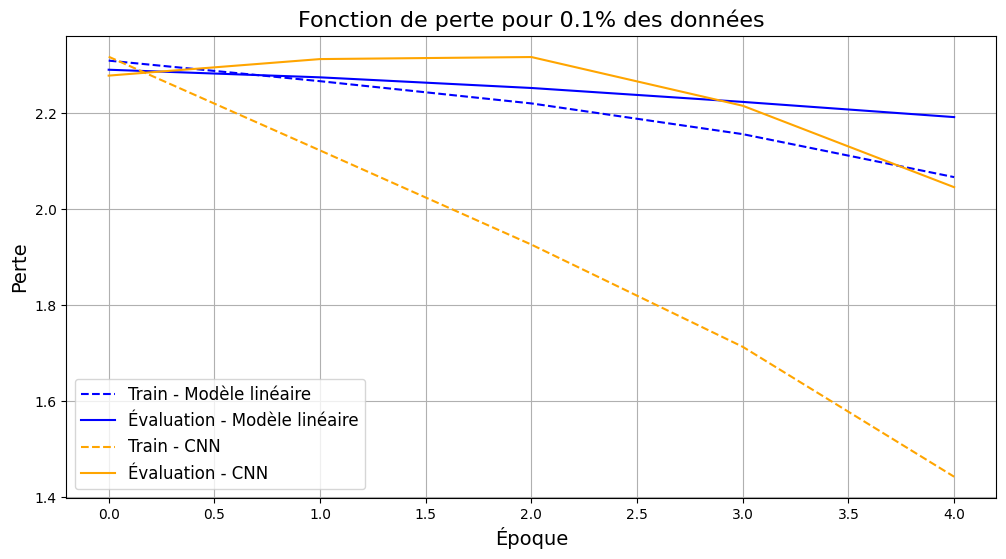

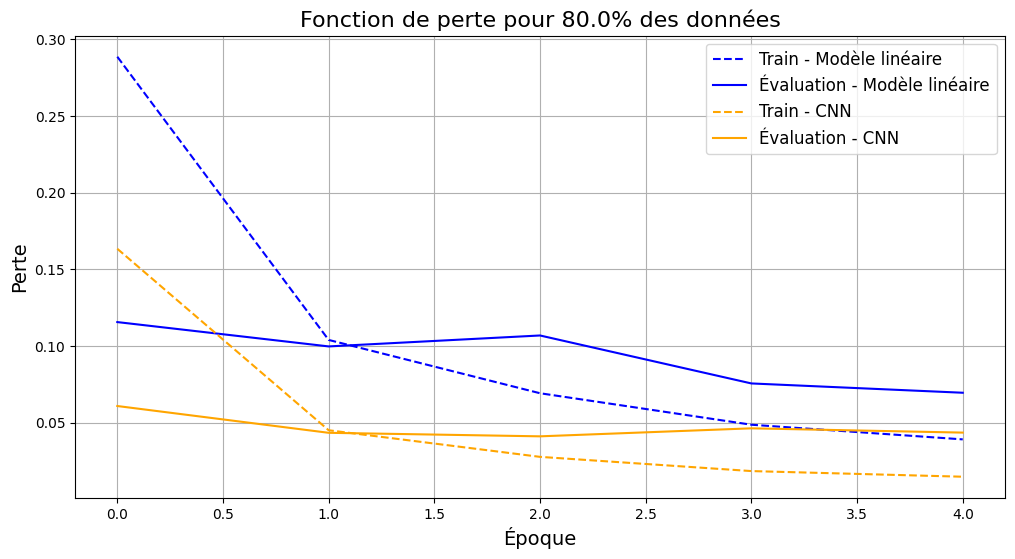

In [12]:
#Partie 1.5


# Fonction d'entraînement et d'évaluation avec enregistrement des pertes
def train_and_record_loss(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    train_losses = []
    eval_losses = []

    for epoch in range(epochs):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Phase d'évaluation
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                eval_loss += loss.item()

        eval_losses.append(eval_loss / len(test_loader))

    return train_losses, eval_losses

# Charger les données MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Pourcentages des données à tester
percentages = [0.001, 0.8]  # 0.1% et 80%

# Tracer les pertes pour les deux modèles
results = {}
for percentage in percentages:
    subset_size = int(len(train_dataset) * percentage)
    subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    subset = Subset(train_dataset, subset_indices)
    train_loader = DataLoader(subset, batch_size=64, shuffle=True)

    # Modèle linéaire
    model_linear = LinearModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_linear.parameters(), lr=0.001)
    train_losses_linear, eval_losses_linear = train_and_record_loss(
        train_loader, test_loader, model_linear, criterion, optimizer
    )

    # Modèle CNN
    model_cnn = CNN().to(device)
    optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
    train_losses_cnn, eval_losses_cnn = train_and_record_loss(
        train_loader, test_loader, model_cnn, criterion, optimizer
    )

    # Enregistrer les résultats
    results[percentage] = {
        "linear": (train_losses_linear, eval_losses_linear),
        "cnn": (train_losses_cnn, eval_losses_cnn),
    }

# Tracer les courbes de perte
for percentage, data in results.items():
    train_linear, eval_linear = data["linear"]
    train_cnn, eval_cnn = data["cnn"]

    plt.figure(figsize=(12, 6))
    plt.plot(train_linear, label="Train - Modèle linéaire", linestyle="--", color="blue")
    plt.plot(eval_linear, label="Évaluation - Modèle linéaire", linestyle="-", color="blue")
    plt.plot(train_cnn, label="Train - CNN", linestyle="--", color="orange")
    plt.plot(eval_cnn, label="Évaluation - CNN", linestyle="-", color="orange")
    plt.xlabel("Époque", fontsize=14)
    plt.ylabel("Perte", fontsize=14)
    plt.title(f"Fonction de perte pour {percentage * 100:.1f}% des données", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()


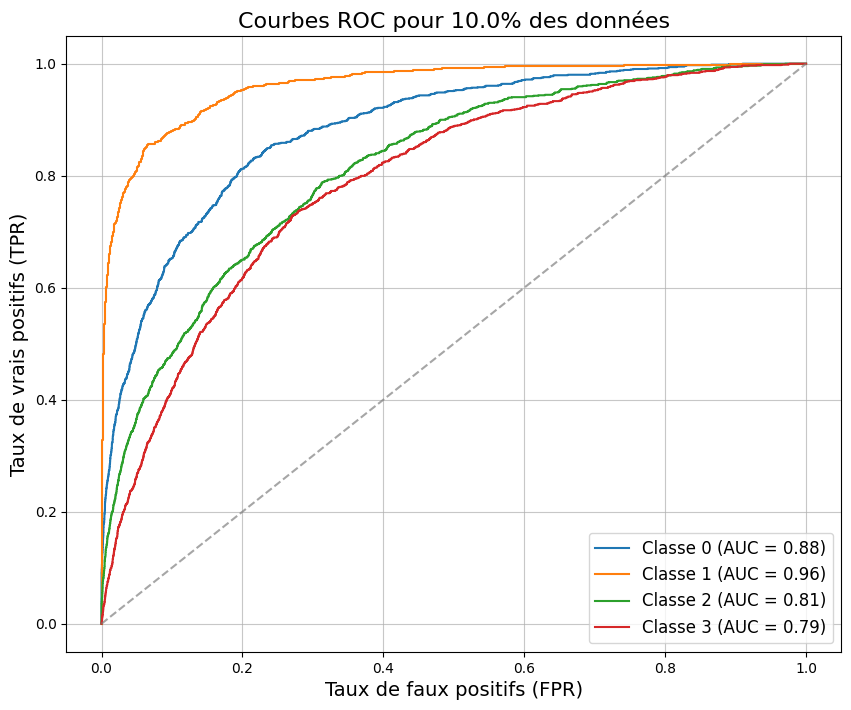

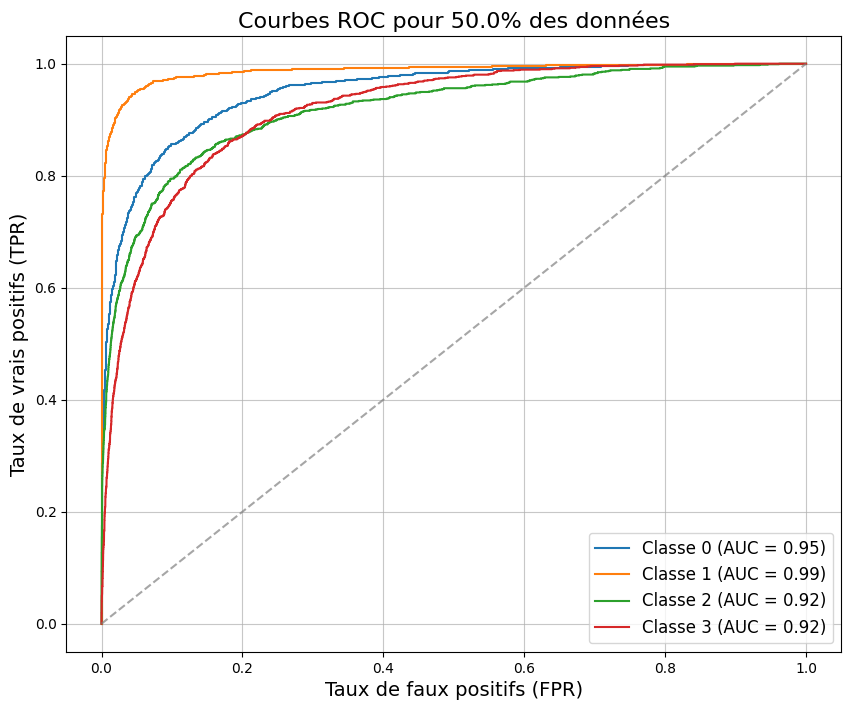

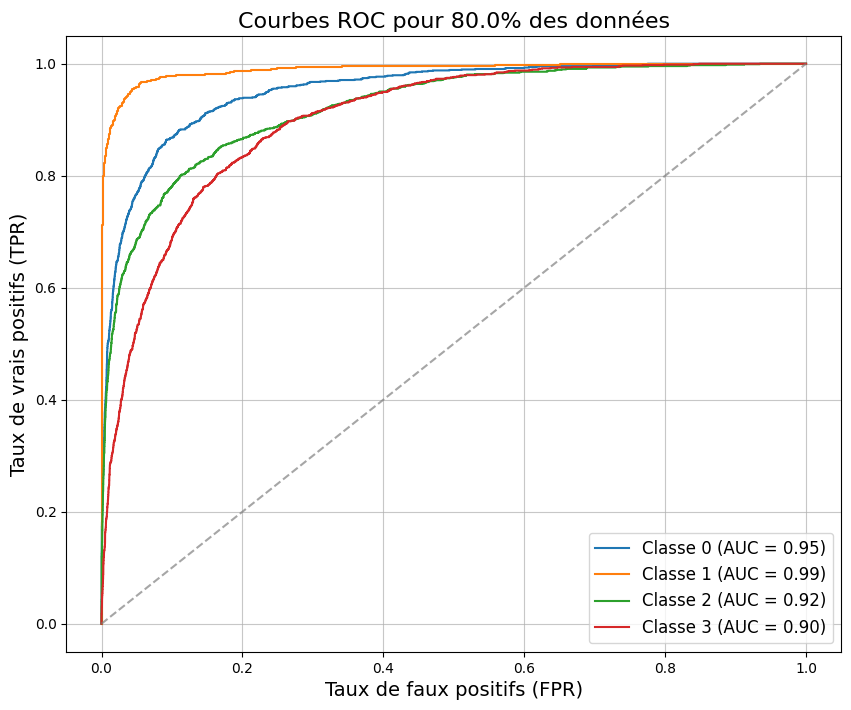

In [8]:
#Partie 1.6


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Définition du modèle avec Dropout et régularisation L2
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  # Couche convolutionnelle
        self.pool = nn.MaxPool2d(2)  # Pooling
        self.dropout = nn.Dropout(0.5)  # Dropout pour éviter le sur-apprentissage
        self.fc1 = nn.Linear(16 * 13 * 13, 64)  # Fully connected 1
        self.fc2 = nn.Linear(64, 10)  # Fully connected 2 (Output layer)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)  # Dropout après la convolution
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout avant la dernière couche
        x = self.fc2(x)
        return x

# Configuration de l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction pour entraîner et obtenir les scores
def train_and_get_scores(train_loader, test_loader, model, criterion, optimizer, l2_lambda, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) + l2_lambda * sum(p.pow(2.0).sum() for p in model.parameters())  # Régularisation L2
            loss.backward()
            optimizer.step()

    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convertir en probabilités
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.vstack(all_probs), np.hstack(all_labels)

# Fonction pour tracer les courbes ROC
def plot_roc_curves(y_true, y_score, classes, title):
    plt.figure(figsize=(10, 8))
    for cls in classes:
        fpr, tpr, _ = roc_curve(y_true[:, cls], y_score[:, cls])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Classe {cls} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)  # Diagonale
    plt.xlabel("Taux de faux positifs (FPR)", fontsize=14)
    plt.ylabel("Taux de vrais positifs (TPR)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.7)
    plt.show()

# Chargement et préparation des données MNIST avec transformations avancées
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Translation et mise à l'échelle
    transforms.ToTensor()
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Séparation stricte des ensembles
indices = np.arange(len(dataset))
np.random.shuffle(indices)

train_indices = indices[:int(0.8 * len(indices))]
test_indices = indices[int(0.8 * len(indices)):]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Taille des ensembles d'entraînement
percentages = [0.1, 0.5, 0.8]
classes_to_plot = [0, 1, 2, 3]
l2_lambda = 0.01  # Coefficient de régularisation L2

# Boucle pour tracer les courbes ROC
for percentage in percentages:
    subset_size = int(len(train_dataset) * percentage)
    subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    train_subset = Subset(train_dataset, subset_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

    # Initialiser le modèle et les paramètres
    model = RegularizedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner le modèle et obtenir les scores
    y_scores, y_true = train_and_get_scores(train_loader, test_loader, model, criterion, optimizer, l2_lambda)

    # Binariser les étiquettes pour les courbes ROC
    y_true_binarized = label_binarize(y_true, classes=range(10))

    # Tracer les courbes ROC
    plot_roc_curves(
        y_true=y_true_binarized,
        y_score=y_scores,
        classes=classes_to_plot,
        title=f"Courbes ROC pour {percentage * 100:.1f}% des données"
    )


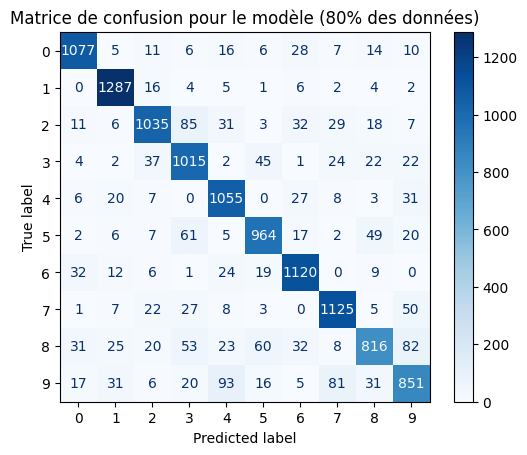

La classe la plus difficile à classifier est : 8


In [9]:
# Partie 1.7

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Définition du modèle ayant obtenu les meilleures performances
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 13 * 13, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Configuration de l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement et préparation des données
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor()
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Séparation stricte des ensembles
indices = np.arange(len(dataset))
np.random.shuffle(indices)

train_indices = indices[:int(0.8 * len(indices))]
test_indices = indices[int(0.8 * len(indices)):]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Entraînement du modèle avec 80 % des données
model = RegularizedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
epochs = 5
model.train()
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Évaluation et génération de la matrice de confusion
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcul et affichage de la matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion pour le modèle (80% des données)")
plt.show()

# Identifier la classe la plus difficile à classifier
incorrect_preds = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
most_difficult_class = np.argmax(incorrect_preds)
print(f"La classe la plus difficile à classifier est : {most_difficult_class}")


In [10]:

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100  # Taille du vecteur latent z
image_size = 28 * 28  # Taille de l'image aplatie (28x28)
batch_size = 64
epochs = 50
output_dir = "./generated_samples"
os.makedirs(output_dir, exist_ok=True)

# Générateur
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size),
            nn.Tanh()  # Sortie entre -1 et 1
        )

    def forward(self, z):
        return self.model(z)

# Discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probabilité
        )

    def forward(self, x):
        return self.model(x)

# Initialisation des réseaux
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Fonctions de perte et optimisateurs
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Préparation des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalisation entre -1 et 1
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Entraînement
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        # Préparer les données réelles
        real_images = images.view(images.size(0), -1).to(device)
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # ---------------------
        # Entraînement du discriminateur
        # ---------------------
        # Images réelles
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Images générées
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Perte totale et mise à jour
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Entraînement du générateur
        # ---------------------
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  # Essayer de tromper le discriminateur

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Affichage des pertes
        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
                  f"D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")

    # Sauvegarde des échantillons générés
    if (epoch + 1) % 5 == 0:
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        save_image(fake_images, os.path.join(output_dir, f"fake_samples_epoch_{epoch+1}.png"), nrow=8, normalize=True)

# print("Entraînement terminé ! Les échantillons générés sont sauvegardés dans le dossier './generated_samples'.")


Epoch [1/50], Step [200/938], D Loss: 0.1788, G Loss: 3.0939, D(x): 0.98, D(G(z)): 0.11
Epoch [1/50], Step [400/938], D Loss: 0.2901, G Loss: 9.7133, D(x): 0.89, D(G(z)): 0.05
Epoch [1/50], Step [600/938], D Loss: 0.0148, G Loss: 15.2618, D(x): 0.99, D(G(z)): 0.00
Epoch [1/50], Step [800/938], D Loss: 0.0022, G Loss: 14.0213, D(x): 1.00, D(G(z)): 0.00
Epoch [2/50], Step [200/938], D Loss: 0.0015, G Loss: 23.2820, D(x): 1.00, D(G(z)): 0.00
Epoch [2/50], Step [400/938], D Loss: 0.1709, G Loss: 11.6962, D(x): 0.93, D(G(z)): 0.04
Epoch [2/50], Step [600/938], D Loss: 0.2894, G Loss: 5.1753, D(x): 0.83, D(G(z)): 0.06
Epoch [2/50], Step [800/938], D Loss: 0.8842, G Loss: 3.5172, D(x): 0.82, D(G(z)): 0.30
Epoch [3/50], Step [200/938], D Loss: 0.2164, G Loss: 3.9787, D(x): 0.96, D(G(z)): 0.11
Epoch [3/50], Step [400/938], D Loss: 0.1504, G Loss: 2.8333, D(x): 0.96, D(G(z)): 0.09
Epoch [3/50], Step [600/938], D Loss: 0.0525, G Loss: 5.1374, D(x): 0.98, D(G(z)): 0.03
Epoch [3/50], Step [800/938]

In [11]:
# Entraînement GAN avec mise à jour du générateur pour maximiser log(D(G(z)))

# Boucle d'entraînement
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        # Préparer les données réelles
        real_images = images.view(images.size(0), -1).to(device)
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # ---------------------
        # Entraînement du discriminateur
        # ---------------------
        # Images réelles
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Images générées
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Perte totale et mise à jour
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Entraînement du générateur
        # ---------------------
        # Maximiser log(D(G(z)))
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = -torch.mean(torch.log(outputs + 1e-8))  # Éviter les gradients nuls avec un epsilon

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Affichage des pertes
        if (i + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
                  f"D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")

    # Sauvegarde des échantillons générés
    if (epoch + 1) % 5 == 0:
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        save_image(fake_images, os.path.join(output_dir, f"fake_samples_epoch_{epoch+1}.png"), nrow=8, normalize=True)

 # print("Entraînement terminé ! Les échantillons générés sont sauvegardés dans le dossier './generated_samples'.")


Epoch [1/50], Step [200/938], D Loss: 0.9740, G Loss: 1.6231, D(x): 0.64, D(G(z)): 0.27
Epoch [1/50], Step [400/938], D Loss: 1.1716, G Loss: 1.2413, D(x): 0.55, D(G(z)): 0.34
Epoch [1/50], Step [600/938], D Loss: 1.1079, G Loss: 1.0487, D(x): 0.63, D(G(z)): 0.39
Epoch [1/50], Step [800/938], D Loss: 1.2037, G Loss: 0.9581, D(x): 0.67, D(G(z)): 0.46
Epoch [2/50], Step [200/938], D Loss: 1.0702, G Loss: 1.1108, D(x): 0.64, D(G(z)): 0.37
Epoch [2/50], Step [400/938], D Loss: 1.0436, G Loss: 1.4383, D(x): 0.68, D(G(z)): 0.37
Epoch [2/50], Step [600/938], D Loss: 1.2121, G Loss: 1.1192, D(x): 0.61, D(G(z)): 0.39
Epoch [2/50], Step [800/938], D Loss: 1.0786, G Loss: 1.3232, D(x): 0.64, D(G(z)): 0.40
Epoch [3/50], Step [200/938], D Loss: 1.1218, G Loss: 1.1666, D(x): 0.60, D(G(z)): 0.34
Epoch [3/50], Step [400/938], D Loss: 1.2455, G Loss: 1.1691, D(x): 0.59, D(G(z)): 0.43
Epoch [3/50], Step [600/938], D Loss: 1.1777, G Loss: 1.2286, D(x): 0.65, D(G(z)): 0.42
Epoch [3/50], Step [800/938], D 

In [ ]:
# Définition du générateur
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)


# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


# Hyperparamètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
z_dim = 100
img_size = 28
img_dim = img_size * img_size
lr = 0.0002
num_epochs = 50

# Prétraitement des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Chargement des données MNIST
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialisation des modèles, des optimisateurs et de la fonction de perte
generator = Generator(z_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)
optim_gen = optim.Adam(generator.parameters(), lr=lr)
optim_disc = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# Entraînement
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.view(-1, img_dim).to(device)
        batch_size = real.size(0)

        # Étiquettes pour les vraies et fausses images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Entraînement du discriminateur
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = generator(noise)
        real_loss = criterion(discriminator(real), real_labels)
        fake_loss = criterion(discriminator(fake.detach()), fake_labels)
        loss_disc = real_loss + fake_loss
        optim_disc.zero_grad()
        loss_disc.backward()
        optim_disc.step()

        # Entraînement du générateur
        output = discriminator(fake)
        loss_gen = criterion(output, real_labels)
        optim_gen.zero_grad()
        loss_gen.backward()
        optim_gen.step()

        # Affichage des pertes
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

    # Sauvegarde des images générées
    with torch.no_grad():
        fake = generator(torch.randn(64, z_dim).to(device)).view(-1, 1, img_size, img_size)
        vutils.save_image(fake, f"./generated_samples/epoch_{epoch+1}.png", normalize=True)

 # print("Entraînement terminé ! Les échantillons générés sont sauvegardés dans le dossier './generated_samples3'.")

In [ ]:
# Définition des hyperparamètres
z_dim = 100  # Dimension de l'espace latent
img_size = 28  # Taille des images MNIST (28x28)
img_dim = 1 * img_size * img_size  # 1 canal (niveaux de gris)
batch_size = 128
lr = 0.0002  # Taux d'apprentissage
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Définition des modèles
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.net(img)

# Initialisation des modèles
generator = Generator(z_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

# 2. Entraînement
# Charger les données MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisation pour Tanh
])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimiseurs et fonction de perte
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Boucle d'entraînement
for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, img_dim).to(device)
        batch_size = real_imgs.size(0)

        # Labels pour le discriminateur
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Entraîner le discriminateur
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        loss_d = real_loss + fake_loss

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Entraîner le générateur
        fake_imgs = generator(z)
        loss_g = criterion(discriminator(fake_imgs), real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Afficher les pertes toutes les 100 itérations
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} "
                  f"Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

# Sauvegarder le modèle générateur
torch.save(generator.state_dict(), './generator.pth')
print("Entraînement terminé ! Modèle générateur sauvegardé.")

# 3. Génération d'échantillons
# Charger le générateur sauvegardé
generator = Generator(z_dim, img_dim).to(device)
generator.load_state_dict(torch.load('./generator.pth'))
generator.eval()

# Générer des échantillons
num_samples = 16
z = torch.randn(num_samples, z_dim).to(device)
generated_imgs = generator(z).view(-1, 1, img_size, img_size).cpu().detach()

# Visualiser les échantillons générés
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title("Échantillons générés")
plt.imshow(vutils.make_grid(generated_imgs, padding=2, normalize=True).permute(1, 2, 0))
plt.show()


In [ ]:


# Charger un jeu de données MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist = MNIST(root="./data", train=False, download=True, transform=transform)

# Obtenir une image et une étiquette
image, label = mnist[0]
image = image.squeeze().numpy()

# Ajouter du bruit gaussien
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Garder les valeurs dans [0, 1]

noisy_image = add_gaussian_noise(image)

# Afficher les images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Image avec bruit gaussien")
plt.imshow(noisy_image, cmap="gray")
plt.show()


In [ ]:

# Charger un jeu de données MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist = MNIST(root="./data", train=False, download=True, transform=transform)

# Obtenir une image et une étiquette
image, label = mnist[0]
image = image.squeeze().numpy()

# Ajouter du bruit gaussien
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Garder les valeurs dans [0, 1]

noisy_image = add_gaussian_noise(image)

# Afficher les images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Image avec bruit gaussien")
plt.imshow(noisy_image, cmap="gray")
plt.show()
